In [1]:
%load_ext autoreload
%autoreload 2

# ERA5 population aggregation

In this notebook, we show how to read a sample daily aggregated ERA5 file, which was
downloaded using [cdsapi](https://cds.climate.copernicus.eu/how-to-api). The `ERA5` class
takes care of reading in the data and population and resampling and/or reprojecting to EPSG:4326
(latitude and longitude, also known as WGS84). First we import the necessary classes:

- `MemoryRaster` is a lower-level class that enables easy manipulation of raster data
  in memory, a feature that `rasterio` does not provide. This class is similar to the R package
  `{terra}`s `SpatRaster` class
- `ERA5` is a class that performs higher level operations on ERA5 NetCDF data files
  and computes population weighted zonal statistics using the
  [`exactextract`](https://isciences.github.io/exactextract/) package
- `ERA5Aggregated` operates on a data lake of parquet files saved from the `ERA5` class
   to offer aggregate weekly or monthly temporal statistics

In [2]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd

from geoglue.memoryraster import MemoryRaster
from geoglue.era5 import ERA5, ERA5Aggregated

Let's read in some files and plot the population

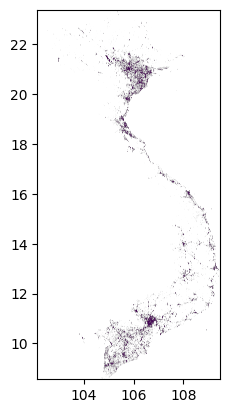

<Axes: >

In [3]:
era5_file = "../79a080c8aaa9b3f1d4808e650202035c.nc"
population = MemoryRaster.read("../data/vnm_ppp_2020_UNadj_constrained.tif", crs="EPSG:4326")
population.plot()

## ERA5 data

ERA5 requires two parameters: the first, a tuple of ISO 3166-2 3-alpha
(country three letter) code and an admin level (1, 2, or 3) and a
population raster.

In [4]:
era5 = ERA5(era5_file, ("VNM", 2), population)
era5

ERA5 VNM admin_level=2 statistic=daily_mean
filename  = '../79a080c8aaa9b3f1d4808e650202035c.nc'
variables = 2m_temperature

The above representation shows the variable in the ERA5 datasets. ERA5 variables have
two forms - short and long. The short form of '2m_temperature' is 't2m'. The ERA5 class
recognizes this and allows you to refer to the data both by the short and long name.

In [5]:
era5["t2m"].shape

(365, 65, 33)

In [6]:
era5["2m_temperature"].shape

(365, 65, 33)

This shows that the `2m_temperature` (or `t2m`) dataset has the shape (365, 65, 33) - in this case,
a 65 by 33 matrix showing the temperature for each day in a year (in this case, we downloaded
data for the year 2022). We can see more information on the variable as well:

In [7]:
era5["t2m"]

<xarray.DataArray 't2m' (valid_time: 365, latitude: 65, longitude: 33)> Size: 3MB
[782925 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 520B 24.0 23.75 23.5 23.25 ... 8.5 8.25 8.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2022-01-01 ... 2022-12-31
  * longitude   (longitude) float64 264B 102.0 102.2 102.5 ... 109.5 109.8 110.0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

All ERA5 datasets will have these three coordinate axes (latitude, longitude and valid_time). We can
see that valid_time ranges from 2022-01-01 to 2022-12-31, so, the entire year of 2022. We can
pick one day from that using either the absolute index with `isel`, or with the full ISO format date
with `sel`. Here, we show the temperature on the first day:

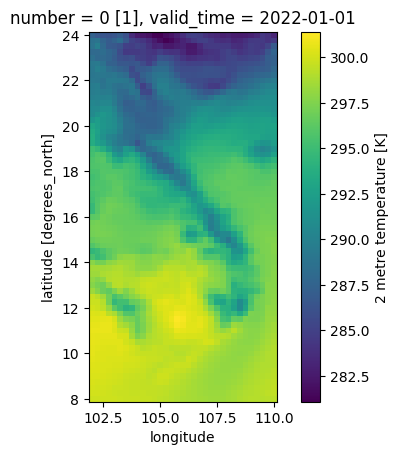

In [8]:
era5["2m_temperature"].isel(valid_time=0).plot().axes.set_aspect("equal")

## Population weighted aggregation

Let us look at the population data:

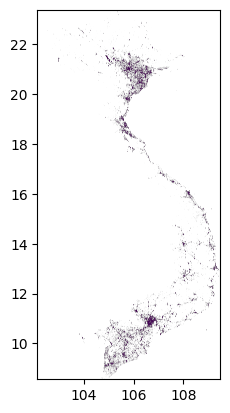

<Axes: >

In [9]:
era5.population.plot()

In [10]:
era5.population.shape

(17796, 8789)

To perform **population-weighted aggregation**, we will first upsample the weather data to match the population raster.
This is done to avoid losing the population granularity (1 km x 1 km) which is of a higher resolution than the weather data.
Upsampling is performed using rasterio's [resampling method](https://rasterio.readthedocs.io/en/stable/topics/resampling.html)
which recommends using bilinear resampling for upsampling continuous data. The resample procedure will create a
raster of the same shape as the population raster, enabling the population raster to be used as weights to the
[exact_extract](https://isciences.github.io/exactextract/exactextract.html) function.

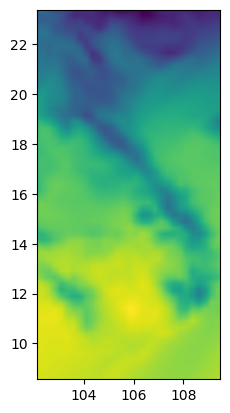

<Axes: >

In [11]:
resampled_t2m = era5.resample("2m_temperature", valid_time=0)  # select the first day to resample
resampled_t2m.plot()

We can check that the resampled `t2m` data and population raster shapes match:

In [12]:
era5.population.shape == resampled_t2m.shape

True

We can now use the `zonal_stats` function of the `MemoryRaster` package to calculate the aggregated zonal statistics
of the temperature to the admin2 level. This multiplies the population pixel and weather pixel (which now match exactly)
along with the spherical (geodesic) area of the pixel intersection with the admin2 level geometry.

In [13]:
r = resampled_t2m.zonal_stats(era5.geom, 'weighted_mean(coverage_weight=area_spherical_m2)', weights=era5.population)
r

/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


,weighted_mean
0,299.376375
1,299.353556
2,299.434328
3,299.507078
4,299.596055
...,...
705,288.118265
706,285.988782
707,287.879397
708,288.731527


ERA5 defines a `zonal_stats` function that uses the `zonal_stats` from `MemoryRaster` to perform
the above computation for a range of dates and defines plotting functions on the resulting
`ERA5Aggregated` object for easier visualisation:

/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/src/geoglue/era5.py:227: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatia

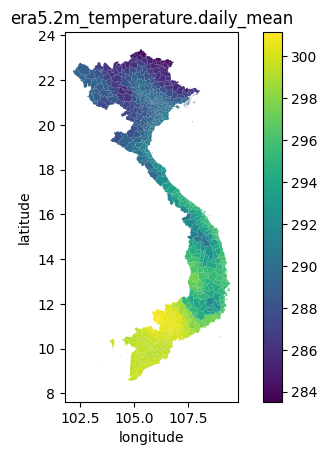

In [14]:
from datetime import date
# Compare with unweighted data to see difference
weighted_temp = era5.zonal_daily("2m_temperature", weighted=True, min_date = date(2022,1,1), max_date=date(2022,1,2))
weighted_temp.plot("2022-01-01")

We can pick only the values column to compare with the equivalent aggregation operation
without population weights

In [15]:
weighted_values = weighted_temp.select_values("2022-01-01")
weighted_values

0      299.376375
1      299.353556
2      299.434328
3      299.507078
4      299.596055
          ...    
705    288.118265
706    285.988782
707    287.879397
708    288.731527
709    289.032977
Name: value, Length: 710, dtype: float64

In [16]:
unweighted_temp = era5.zonal_daily("2m_temperature", weighted=False, min_date = date(2022,1,1), max_date=date(2022,1,2))
unweighted_values = unweighted_temp.select_values("2022-01-01")
unweighted_values

/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/src/geoglue/era5.py:227: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
100%|█| 2/2 [00:1


0      299.379290
1      299.328620
2      299.389665
3      299.452402
4      299.596622
          ...    
705    287.870838
706    286.379536
707    287.406023
708    288.661224
709    288.979096
Name: value, Length: 710, dtype: float64

We can display the difference between these two sets of values:

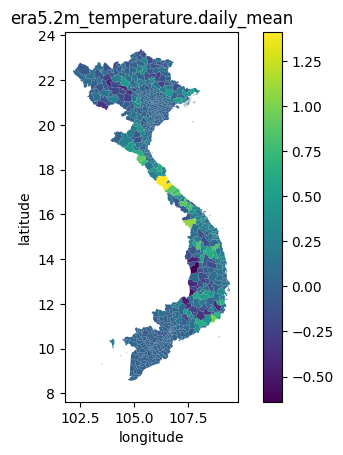

In [17]:
difference_weighted_unweighted = weighted_temp.select("2022-01-01").reset_index(drop=True)
difference_weighted_unweighted["value"] = weighted_values - unweighted_values
weighted_temp.with_data(difference_weighted_unweighted).plot("2022-01-01")